In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import warnings

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

warnings.filterwarnings('ignore')

Mias informações sobre o projeto, CRISP-DM, suas etapas e planejamento geral no arquivo da aula.

In [258]:
df = pd.read_csv('demo01.csv')

print(f'Número de linhas: {df.shape[0]}\nNúmero de colunas: {df.shape[1]}\n')

print(f'Proporção da variável alvo:\n{df['mau'].value_counts(normalize=True)}\n')

print(f'Contagem da variável alvo:\n{df['mau'].value_counts()}')

Número de linhas: 16650
Número de colunas: 16

Proporção da variável alvo:
mau
False    0.976577
True     0.023423
Name: proportion, dtype: float64

Contagem da variável alvo:
mau
False    16260
True       390
Name: count, dtype: int64


In [259]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['missing'] = df.isnull().sum()
metadados['valores_unicos'] = df.nunique()

metadados

,dtype,missing,valores_unicos
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6
idade,float64,0,5298
tempo_emprego,float64,0,3005


In [260]:
# transformando a variável resposta

df['mau'] = df['mau'].astype('int64')

Amostragem

4. Amostras balanceadas<br>
Amostras balanceadas em geral trazem 50% de bons e 50% de maus em um desenho *1 pra 1* de eventos e não eventos. Comparando com amostras de mesmo tamanho, esse desenho traz eficiência no sentido de estimar as razões de chances com erro padrão menor possível - fornecendo, portanto, testes mais poderosos para os parâmetros da logística. A desvantagem é que há a necessidade de uma *correção* na hora de se calcular uma probabilidade direto da equação da regressão. Há várias formas de se realizar esta correção, a mais popular é através de uma ponderação.<br>
Definimos pesos $w_i$ para cada indivíduo da amostra com a regra abaixo, e rodamos a regressão normalmente, indicando estes ponderadores:
$$
w_i = 
    \begin{cases}
    \ \rho_{bom}\pi_{bom}    & \text{se classe='bom'} \\
    \rho_{mau}\pi_{mau},              & \text{se classe='mau'}
    \end{cases}
$$
Em que $\rho_{bom}$ e $\rho_{mau}$ são as proporções na amostra de bons e maus, respectivamente, e $\pi_{bom}$ e $\pi_{mau}$ são as proporções populacionais de bons e maus respectivamente.

In [261]:
df_amostra = pd.concat([df[df['mau'] == 1], df[df['mau'] == 0].sample(n=390)])
tab_am = df_amostra['mau'].value_counts()
tab_am

mau
1    390
0    390
Name: count, dtype: int64

In [262]:
tab_pop = df['mau'].value_counts()
tab_pop

mau
0    16260
1      390
Name: count, dtype: int64

In [263]:
# Construíndo os ponderadores:

rho_bom = tab_am.loc[0]/tab_am.sum()
rho_mau = tab_am.loc[1]/tab_am.sum()

pi_bom = tab_pop.loc[0]/tab_pop.sum()
pi_mau = tab_pop.loc[1]/tab_pop.sum()

w_bom = pi_bom*rho_bom
w_mau = pi_mau*rho_mau

print(f'w_bom: {round(w_bom, 2)}\nw_mau: {round(w_mau, 2)}')

w_bom: 0.49
w_mau: 0.01


In [264]:
df_amostra.loc[df_amostra['mau'] == 0, 'w'] = w_bom
df_amostra.loc[df_amostra['mau'] == 1, 'w'] = w_mau

# Retornando a proporção inicial da população:

df_amostra.groupby('mau')['w'].sum()/df_amostra['w'].sum()

mau
0    0.976577
1    0.023423
Name: w, dtype: float64

Ao rodar a regressão logística, podemos passar como parâmtro o ponderador para obtermos as probabilidades corretas.

# Desenvolvimento

Nesta etapa, tipicamente fazemos diversas versões de modelo para cada segmento, e eventualmente, diversos modelos diferentes com diferentes algoritmos, comparamos, e escolhemos o melhor.

Vale frisar que normalmente a fonte de melhoria do modelo mais importante vai estar nas variáveis de entrada. Quanto melhor forem e mais bem trabalhadas, melhor vai ser o modelo. Há melhorias com relação à parametrização do modelo, algoritmo, linearizações, interações etc, e em geral buscamos todos esses fatores que possam melhorar a capacidade discriminante. Os passos dessa etapa:

- Análise exploratória
- Seleção de variáveis
- Tratamento de valores faltantes e outliers
- Agrupamento de categorias
- Equação preliminar
- Inferência de rejeitados
- Produção do escorecard final
- Validação

### Análise exploratória:

In [265]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [266]:
metadados['papel'] = 'covariavel'
metadados.loc['mau', 'papel'] = 'resposta'


metadados

,dtype,missing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,float64,0,5298,covariavel
tempo_emprego,float64,0,3005,covariavel


Para variáveis com muitos valores únicos, é necessário categorizar:

In [267]:
# Aumentar o número de categorias aumenta o information value:

for i in range(10, 60, 10):
    iv =IV(pd.qcut(df['idade'], i, duplicates='drop'), df['mau'])
    print(iv)

0.055553154972220395
0.09549790232951168
0.14315137226697472
0.16276730922497706
0.23847772446767088


In [268]:
for var in metadados[metadados['papel']=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],25,duplicates='drop'), df['mau'])
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df['mau'])

    
metadados

,dtype,missing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.005461
posse_de_veiculo,object,0,2,covariavel,0.002167
posse_de_imovel,object,0,2,covariavel,0.030016
qtd_filhos,int64,0,8,covariavel,0.004720
tipo_renda,object,0,5,covariavel,inf
educacao,object,0,5,covariavel,inf
estado_civil,object,0,5,covariavel,0.047624
tipo_residencia,object,0,6,covariavel,0.015773
idade,float64,0,5298,covariavel,0.104608
tempo_emprego,float64,0,3005,covariavel,0.260524


In [269]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()

    plt.subplots_adjust(hspace=0.5)
    
    return biv

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Civil marriage,1251,32,0.024942,Civil marriage,1283,0.004354,0.033483,0.016400,-3.665963,-3.362667,-4.093920,0.064354,0.367650,-0.363604
Married,11439,241,0.020634,Married,11680,0.001315,0.023212,0.018055,-3.859987,-3.739607,-3.996097,-0.129670,-0.009290,-0.265781
Separated,922,23,0.024339,Separated,945,0.005013,0.034176,0.014501,-3.691051,-3.341453,-4.218925,0.039266,0.388864,-0.488609
Single / not married,1972,63,0.030958,Single / not married,2035,0.003840,0.038488,0.023428,-3.443669,-3.218160,-3.730098,0.286648,0.512157,0.000219
Widow,676,31,0.043847,Widow,707,0.007701,0.058966,0.028728,-3.082206,-2.770017,-3.520720,0.648111,0.960300,0.209597


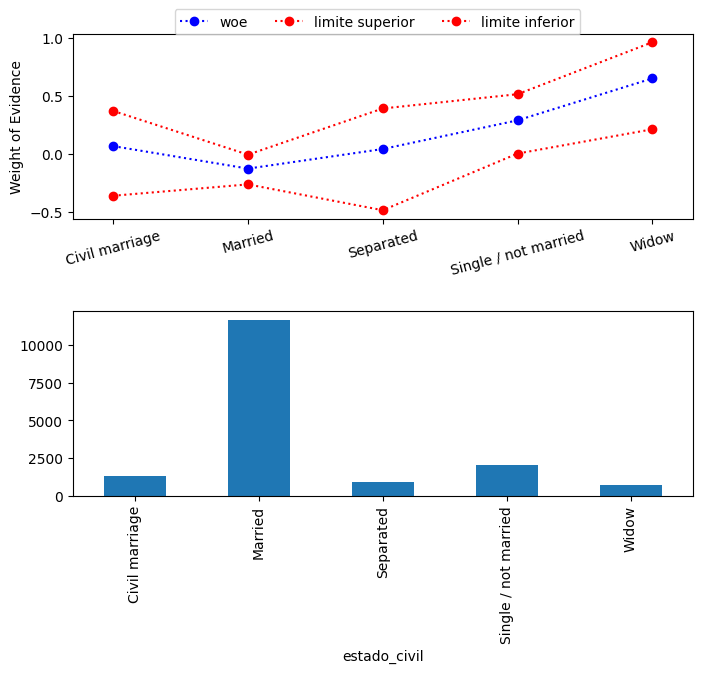

In [270]:
biv_discreta('estado_civil', df)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Commercial associate,3728,98,0.025614,Commercial associate,3826,0.002554,0.030622,0.020607,-3.638660,-3.454946,-3.861315,0.091657,0.275371,-0.130998
Pensioner,2722,78,0.027857,Pensioner,2800,0.003110,0.033955,0.021759,-3.552413,-3.348169,-3.805724,0.177903,0.382148,-0.075407
State servant,1425,26,0.017919,State servant,1451,0.003483,0.024750,0.011087,-4.003831,-3.673869,-4.490799,-0.273514,0.056448,-0.760483
Student,8,0,0.000000,Student,8,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
Working,8377,188,0.021950,Working,8565,0.001583,0.025053,0.018846,-3.796803,-3.661380,-3.952409,-0.066487,0.068936,-0.222092


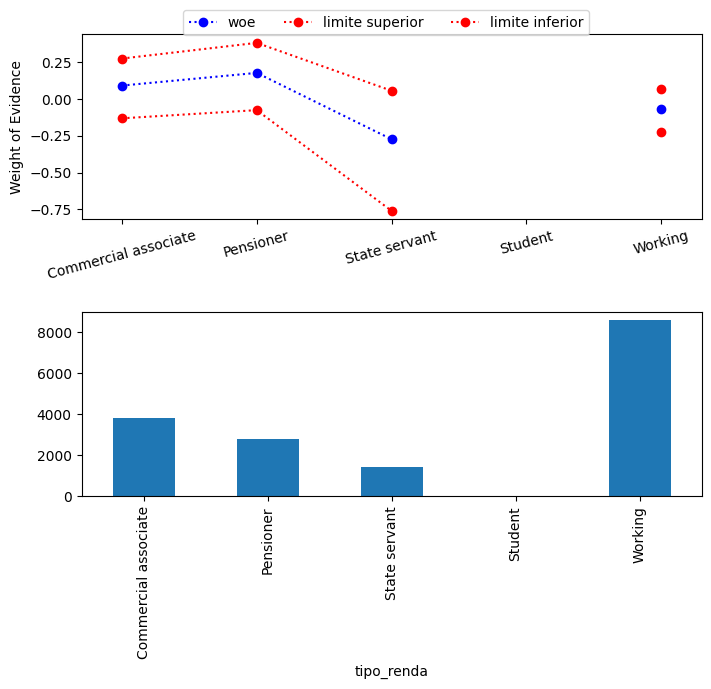

In [271]:
biv_discreta('tipo_renda', df)

Student deu problema pois o número de 'maus' é zero, assim dando problema nos calculos da razão de chance e WOE. Nestes casos é interessante agrupar esta classe com outra semelhante.

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Commercial associate,3728,98,0.025614,Commercial associate,3826,0.002554,0.030622,0.020607,-3.638660,-3.454946,-3.861315,0.091657,0.275371,-0.130998
Pensioner,2722,78,0.027857,Pensioner,2800,0.003110,0.033955,0.021759,-3.552413,-3.348169,-3.805724,0.177903,0.382148,-0.075407
St. ser./Stud.,1433,26,0.017820,St. ser./Stud.,1459,0.003464,0.024615,0.011026,-4.009429,-3.679494,-4.496387,-0.279112,0.050823,-0.766071
Working,8377,188,0.021950,Working,8565,0.001583,0.025053,0.018846,-3.796803,-3.661380,-3.952409,-0.066487,0.068936,-0.222092


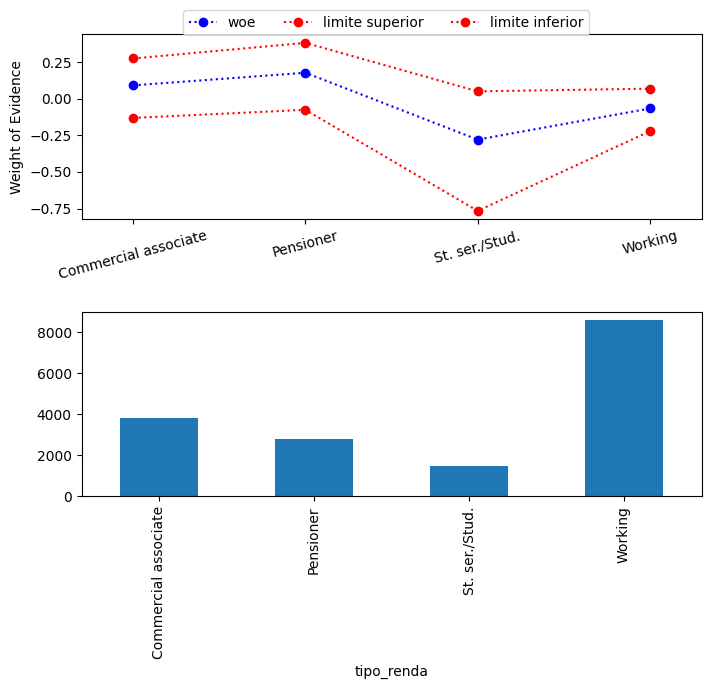

In [272]:
df2 = df.copy()
df2.tipo_renda.replace({'Student': 'St. ser./Stud.', 'State servant': 'St. ser./Stud.'}, inplace=True)
biv_discreta('tipo_renda', df2)

In [273]:
IV(df2.tipo_renda, df.mau)

0.0160100868136515

Para a educação temos o mesmo caso:

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Academic degree,17,0,0.000000,Academic degree,17,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
Higher education,4436,115,0.025269,Higher education,4551,0.002326,0.029830,0.020708,-3.652576,-3.481955,-3.856295,0.077740,0.248362,-0.125978
Incomplete higher,624,25,0.038521,Incomplete higher,649,0.007554,0.053355,0.023687,-3.217275,-2.875962,-3.718861,0.513042,0.854354,0.011456
Lower secondary,181,7,0.037234,Lower secondary,188,0.013809,0.064475,0.009993,-3.252587,-2.674833,-4.595800,0.477730,1.055483,-0.865483
Secondary / secondary special,11002,243,0.021610,Secondary / secondary special,11245,0.001371,0.024297,0.018922,-3.812771,-3.692789,-3.948336,-0.082454,0.037528,-0.218020


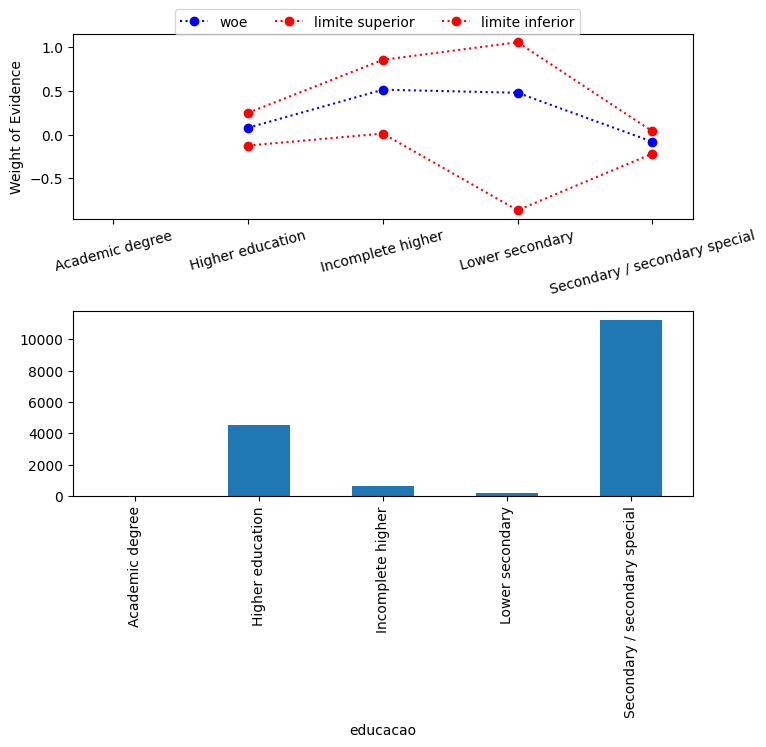

In [274]:
biv_discreta('educacao', df)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Academic/Higher,4453,115,0.025175,Academic/Higher,4568,0.002318,0.029719,0.020631,-3.656401,-3.485791,-3.860113,0.073915,0.244526,-0.129796
Incomplete higher,624,25,0.038521,Incomplete higher,649,0.007554,0.053355,0.023687,-3.217275,-2.875962,-3.718861,0.513042,0.854354,0.011456
Lower secondary,181,7,0.037234,Lower secondary,188,0.013809,0.064475,0.009993,-3.252587,-2.674833,-4.595800,0.477730,1.055483,-0.865483
Secondary / secondary special,11002,243,0.021610,Secondary / secondary special,11245,0.001371,0.024297,0.018922,-3.812771,-3.692789,-3.948336,-0.082454,0.037528,-0.218020


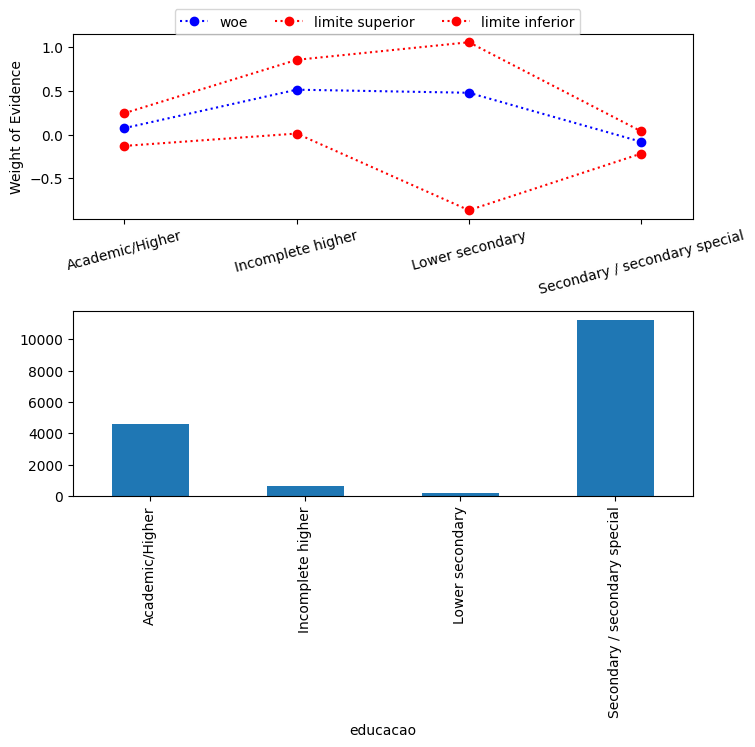

In [275]:
df2.educacao.replace({'Academic degree':'Academic/Higher', 'Higher education': 'Academic/Higher'}, inplace=True)
biv_discreta('educacao', df2)

In [276]:
IV(df2.educacao, df.mau)

0.022423939874047925

Agrupando as daus categorias com menos frequência:

0.009807762437895476

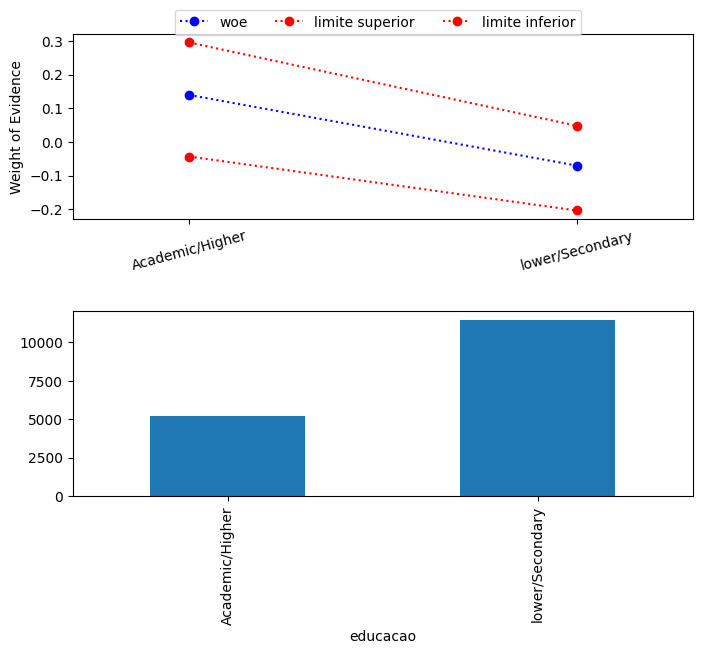

In [277]:
df2.educacao.replace({'Incomplete higher':'Academic/Higher', 
                      'Lower secondary':'lower/Secondary',
                      'Secondary / secondary special': 'lower/Secondary'
                     }, inplace=True)
biv_discreta('educacao', df2)
IV(df2.educacao, df.mau)

In [278]:
IV(df2.educacao, df.mau)

0.009807762437895476

Esta agregação das categorias diminuiu o information value, logo provavelmente ela não é interessante para o modelo final.

In [279]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

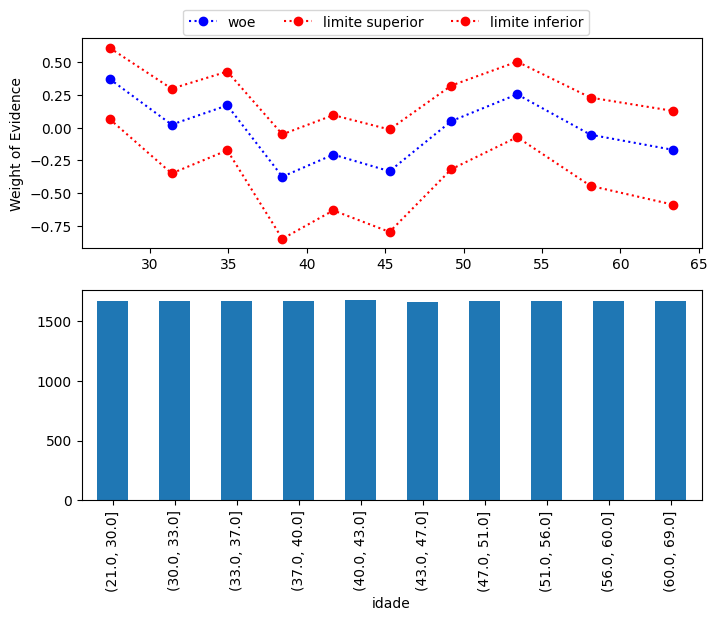

In [280]:
biv_continua('idade', 10, df)

In [281]:
# Corrigindo valores do tempo de emprego:

df.loc[df['tempo_emprego'] <0, 'tempo_emprego'] = -1
df2.loc[df2['tempo_emprego']<0,'tempo_emprego'] = -1

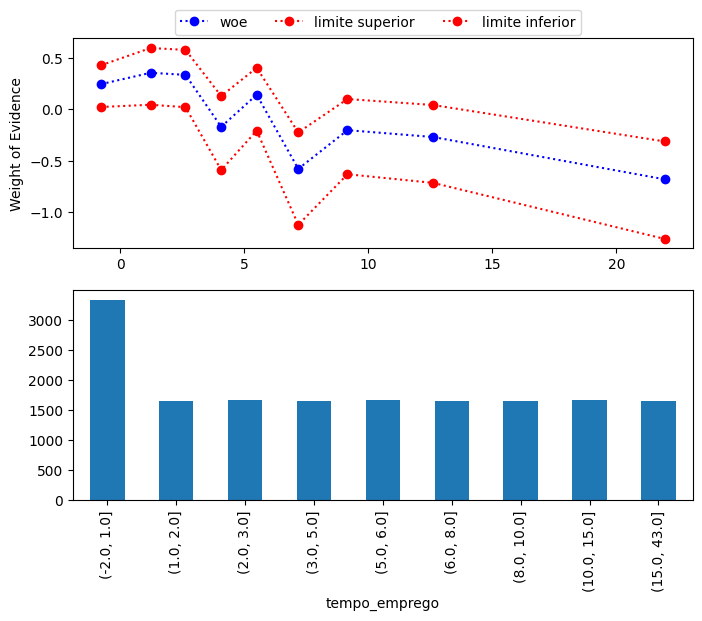

In [282]:
biv_continua('tempo_emprego', 10, df)

# Desenvolvimento do modelo

In [283]:
# Ajuda para definir a equação:

f =' + '.join(list(df.columns.drop(['mau', 'bom'])))

In [284]:
formula = f'mau ~ {f}'
formula

'mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + possui_celular + possui_fone_comercial + possui_fone + possui_email + qt_pessoas_residencia'

Lembrando que, existe um zero estrutural no WOE da variável 'educacao', isso afeta o modelo:

In [285]:
rl = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                16650
Model:                            GLM   Df Residuals:                    16622
Model Family:                Binomial   Df Model:                           27
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 26 Apr 2024   Deviance:                       35920.
Time:                        18:01:21   Pearson chi2:                 1.76e+18
No. Iterations:                    28   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                 -2.632e+15   1.35e+07  -1.95e+08      0.000   -2.63e+15   -2.63e+15
sexo[T.M]                                  4.857e+13   1.23e+06   3.95e+07      0.000    4.86e+13    4.86e+13
posse_de_veiculo[T.Y]                     -3.257e+13   1.17e+06  -2.78e+07      0.000   -3.26e+13   -3.26e+13
posse_de_imovel[T.Y]                      -6.594e+13   1.16e+06  -5.66e+07      0.000   -6.59e+13   -6.59e+13
tipo_renda[T.Pensioner]                    4.414e+12   2.32e+06    1.9e+06      0.000    4.41e+12    4.41e+12
tipo_renda[T.State servant]               -4.823e+13   2.11e+06  -2.29e+07      0.000   -4.82e+13   -4.82e+13
tipo_renda[T.Student]                     -1.104e+14   2.38e+07  -4.63e+06      0.000    -1.1e+14    -1.1e+14
tipo_renda[T.Working]                     -2.649e+13   1.32e+06     -2e+07      0.000   -2.65e+13   -2.65e+13
educacao[T.Higher education]               2.133e+14   1.63e+07   1.31e+07      0.000    2.13e+14    2.13e+14
educacao[T.Incomplete higher]              3.005e+14   1.65e+07   1.82e+07      0.000    3.01e+14    3.01e+14
educacao[T.Lower secondary]                2.984e+14    1.7e+07   1.75e+07      0.000    2.98e+14    2.98e+14
educacao[T.Secondary / secondary special]  1.713e+14   1.63e+07   1.05e+07      0.000    1.71e+14    1.71e+14
estado_civil[T.Married]                   -3.354e+13   1.99e+06  -1.69e+07      0.000   -3.35e+13   -3.35e+13
estado_civil[T.Separated]                  5.443e+14   1.02e+07   5.33e+07      0.000    5.44e+14    5.44e+14
estado_civil[T.Single / not married]       5.889e+14      1e+07   5.88e+07      0.000    5.89e+14    5.89e+14
estado_civil[T.Widow]                      7.316e+14   1.03e+07   7.09e+07      0.000    7.32e+14    7.32e+14
tipo_residencia[T.House / apartment]      -1.305e+14   8.02e+06  -1.63e+07      0.000    -1.3e+14    -1.3e+14
tipo_residencia[T.Municipal apartment]      6.42e+11   8.54e+06   7.52e+04      0.000    6.42e+11    6.42e+11
tipo_residencia[T.Office apartment]        3.253e+13   1.01e+07   3.23e+06      0.000    3.25e+13    3.25e+13
tipo_residencia[T.Rented apartment]       -1.333e+14   9.16e+06  -1.45e+07      0.000   -1.33e+14   -1.33e+14
tipo_residencia[T.With parents]           -2.078e+14   8.37e+06  -2.48e+07      0.000   -2.08e+14   -2.08e+14
qtd_filhos                                -5.241e+14   9.83e+06  -5.33e+07      0.000   -5.24e+14   -5.24e+14
idade                                     -1.574e+12   6.84e+04   -2.3e+07      0.000   -1.57e+12   -1.57e+12
tempo_emprego                             -6.863e+12   9.19e+04  -7.47e+07      0.000   -6.86e+12   -6.86e+12
possui_celular                            -2.632e+15   1.35e+07  -1.95e+08      0.000   -2.63e+15   -2.63e+15
pos

Regressão com as correções:

In [286]:
rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                16650
Model:                            GLM   Df Residuals:                    16626
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1804.0
Date:                Fri, 26 Apr 2024   Deviance:                       3607.9
Time:                        18:01:21   Pearson chi2:                 5.03e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.005450
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -3.2764      0.765     -4.282      0.000      -4.776      -1.777
sexo[T.M]                                  0.2212      0.120      1.841      0.066      -0.014       0.457
posse_de_veiculo[T.Y]                     -0.1467      0.117     -1.252      0.210      -0.376       0.083
posse_de_imovel[T.Y]                      -0.3046      0.111     -2.755      0.006      -0.521      -0.088
tipo_renda[T.Pensioner]                   -0.0206      0.227     -0.091      0.928      -0.466       0.425
tipo_renda[T.St. ser./Stud.]              -0.2603      0.227     -1.148      0.251      -0.705       0.184
tipo_renda[T.Working]                     -0.1303      0.129     -1.013      0.311      -0.383       0.122
educacao[T.lower/Secondary]               -0.2387      0.113     -2.118      0.034      -0.460      -0.018
estado_civil[T.Married]                   -0.1727      0.192     -0.899      0.369      -0.549       0.204
estado_civil[T.Separated]                  1.9503      0.720      2.709      0.007       0.539       3.361
estado_civil[T.Single / not married]       2.1056      0.673      3.130      0.002       0.787       3.424
estado_civil[T.Widow]                      2.6454      0.717      3.689      0.000       1.240       4.051
tipo_residencia[T.House / apartment]      -0.0641      0.724     -0.089      0.929      -1.483       1.355
tipo_residencia[T.Municipal apartment]     0.4347      0.759      0.573      0.567      -1.052       1.922
tipo_residencia[T.Office apartment]        0.5404      0.857      0.631      0.528      -1.139       2.220
tipo_residencia[T.Rented apartment]       -0.0528      0.833     -0.063      0.950      -1.686       1.580
tipo_residencia[T.With parents]           -0.4179      0.768     -0.544      0.586      -1.924       1.088
qtd_filhos                                -1.8514      0.670     -2.763      0.006      -3.165      -0.538
idade                                     -0.0082      0.007     -1.229      0.219      -0.021       0.005
tempo_emprego                             -0.0463      0.012     -3.982      0.000      -0.069      -0.024
possui_celular                            -3.2764      0.765     -4.282      0.000      -4.776      -1.777
possui_fone_comercial                      0.2384      0.132      1.805      0.071      -0.020       0.497
possui_fone                                0.0783      0.117      0.671      0.502      -0.150       0.307
possui_email                              -0.1774      0.195     -0.908      0.364      -0.561       0.206
qt_pessoas_residencia                      1.9219      0.663      2.900      0.004       0.623       3.221
=======================================================================================

Seleção de variáveis

In [287]:
metadados.sort_values(by='IV', ascending=False)

,dtype,missing,valores_unicos,papel,IV
tipo_renda,object,0,5,covariavel,inf
educacao,object,0,5,covariavel,inf
tempo_emprego,float64,0,3005,covariavel,0.260524
idade,float64,0,5298,covariavel,0.104608
estado_civil,object,0,5,covariavel,0.047624
posse_de_imovel,object,0,2,covariavel,0.030016
tipo_residencia,object,0,6,covariavel,0.015773
possui_fone_comercial,int64,0,2,covariavel,0.010950
qt_pessoas_residencia,float64,0,9,covariavel,0.006691
sexo,object,0,2,covariavel,0.005461


Das variáveis com problema no IV, educação apresenta baixo P value, assim podemos mante-los no modelo.

Selecionando as variáveis com IV maior que 0.01

In [288]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'tipo_renda + educacao + tempo_emprego + idade + estado_civil + posse_de_imovel + tipo_residencia + possui_fone_comercial + qt_pessoas_residencia + sexo + qtd_filhos + possui_fone + posse_de_veiculo + possui_email + possui_celular + mau'

In [289]:
formula = '''
        mau ~ educacao + tempo_emprego + idade + estado_civil
        + posse_de_imovel + tipo_residencia + possui_fone_comercial
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                16650
Model:                            GLM   Df Residuals:                    16635
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1810.9
Date:                Fri, 26 Apr 2024   Deviance:                       3621.8
Time:                        18:01:22   Pearson chi2:                 1.71e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.004622
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -2.7789      0.774     -3.592      0.000      -4.295      -1.262
educacao[T.lower/Secondary]               -0.2106      0.111     -1.905      0.057      -0.427       0.006
estado_civil[T.Married]                   -0.1620      0.191     -0.847      0.397      -0.537       0.213
estado_civil[T.Separated]                  0.0413      0.279      0.148      0.882      -0.505       0.587
estado_civil[T.Single / not married]       0.2204      0.221      0.996      0.319      -0.213       0.654
estado_civil[T.Widow]                      0.6827      0.267      2.556      0.011       0.159       1.206
posse_de_imovel[T.Y]                      -0.3121      0.110     -2.830      0.005      -0.528      -0.096
tipo_residencia[T.House / apartment]      -0.0100      0.722     -0.014      0.989      -1.425       1.405
tipo_residencia[T.Municipal apartment]     0.4840      0.757      0.640      0.522      -0.999       1.967
tipo_residencia[T.Office apartment]        0.6366      0.854      0.745      0.456      -1.038       2.311
tipo_residencia[T.Rented apartment]       -0.0090      0.831     -0.011      0.991      -1.638       1.620
tipo_residencia[T.With parents]           -0.3711      0.767     -0.484      0.628      -1.874       1.132
tempo_emprego                             -0.0506      0.010     -5.111      0.000      -0.070      -0.031
idade                                     -0.0086      0.005     -1.720      0.085      -0.018       0.001
possui_fone_comercial                      0.2701      0.123      2.195      0.028       0.029       0.511
==========================================================================================================
"""

In [290]:
# Retirando o tipo_residencia

formula = '''
        mau ~ educacao + tempo_emprego + idade + estado_civil
        + posse_de_imovel + possui_fone_comercial
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                16650
Model:                            GLM   Df Residuals:                    16640
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1814.7
Date:                Fri, 26 Apr 2024   Deviance:                       3629.4
Time:                        18:01:22   Pearson chi2:                 1.71e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.004164
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.8415      0.287     -9.894      0.000      -3.404      -2.279
educacao[T.lower/Secondary]             -0.1980      0.110     -1.796      0.072      -0.414       0.018
estado_civil[T.Married]                 -0.1532      0.191     -0.802      0.423      -0.528       0.221
estado_civil[T.Separated]                0.0476      0.278      0.171      0.864      -0.498       0.593
estado_civil[T.Single / not married]     0.2273      0.221      1.029      0.304      -0.206       0.660
estado_civil[T.Widow]                    0.6820      0.267      2.556      0.011       0.159       1.205
posse_de_imovel[T.Y]                    -0.3286      0.108     -3.048      0.002      -0.540      -0.117
tempo_emprego                           -0.0494      0.010     -5.013      0.000      -0.069      -0.030
idade                                   -0.0073      0.005     -1.491      0.136      -0.017       0.002
possui_fone_comercial                    0.2569      0.123      2.095      0.036       0.017       0.497
========================================================================================================
"""

In [291]:
df2['score'] = rl.predict(df2)

# Acurácia
acc = metrics.accuracy_score(df2.mau, df2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 97.5% 
AUC: 61.6% 
GINI: 23.1%
KS: 18.2%


## Relatórios gerenciais do modelo

Nesta etapa vamos avaliar as contribuições do nosso scorecard ao processo. A avaliação numérica/estatística, que avalia o poder discriminante já foi realizada no passo anterior. Agora é o momento de avaliar uma expectativa de redução na inadimplência ou ganho financeiro.

Duas análises populares são:

- Tabela de ganhos
- Relatório de características

### Relatório de características

In [292]:
def perfil_var(df, var, ev='mau', score='score', ncat=None):
    
    _df = df.copy()
    _df['ev'] = _df[ev]
    _df['nev'] = 1 - _df[ev]
    
    if ncat == None:
        g = _df.groupby(var)
    else:
        g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))

    tg = g.agg({score:'mean', 'ev':'sum', 'nev':'sum'})
    tg['total'] = tg.ev + tg.nev
    tg['distribuição'] = tg.total/tg.total.sum()

    tg['total_acum'] = tg['total'].cumsum()
    tg['ev_acum']    = tg.ev.cumsum()
    tg['nev_acum']   = tg.nev.cumsum()

    tg['tx_ev']     = tg.ev/tg.total
    tg['ep']        = (tg.tx_ev*(1-tg.tx_ev)/tg.total)**.5
    tg['tx_ev_sup'] = tg.score+t.ppf([0.025], tg.total-1)*tg.ep
    tg['tx_ev_inf'] = tg.score+t.ppf([0.975], tg.total-1)*tg.ep

    fig, ax = plt.subplots()
    
    if ncat == None:
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    else:
        tg[var+'_med'] = g[var].mean()
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
        plt.legend()
    return tg[['distribuição', score, 'tx_ev']]


In [293]:
df2.tempo_emprego.describe()

count    16650.000000
mean         6.275232
std          6.905563
min         -1.000000
25%          1.183562
50%          4.691781
75%          9.088356
max         42.906849
Name: tempo_emprego, dtype: float64

,tempo_emprego,distribuição,score,tx_ev
0,"(-1.001, 0.6]",20.0%,2.8%,3.0%
1,"(0.6, 3.384]",20.0%,2.9%,3.3%
2,"(3.384, 6.367]",20.0%,2.5%,2.3%
3,"(6.367, 10.436]",19.9%,2.1%,1.6%
4,"(10.436, 42.907]",20.0%,1.4%,1.5%


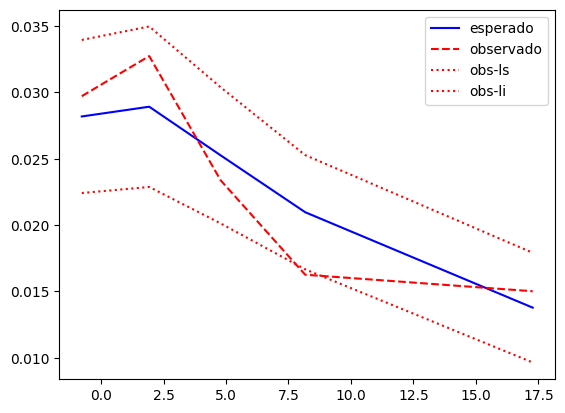

In [294]:
tg = perfil_var(df2, 'tempo_emprego', ncat=5)
tg.reset_index().style.format({'score': '{:.1%}', 'tx_ev': '{:.1%}', 'distribuição': '{:.1%}'})

,distribuição,score,tx_ev
idade,,,
"(22.029, 33.148]",0.20024,0.028806,0.028794
"(33.148, 40.06]",0.19988,0.023262,0.021935
"(40.06, 47.213]",0.19988,0.020826,0.018029
"(47.213, 55.611]",0.20006,0.019719,0.027319
"(55.611, 68.91]",0.19994,0.024498,0.021027


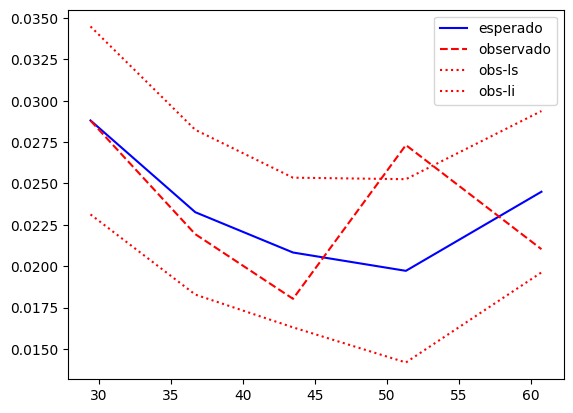

In [295]:
tg = perfil_var(df2, 'idade', ncat=5)
tg

,distribuição,score,tx_ev
score,,,
"(0.0012499999999999998, 0.0158]",0.20036,0.011751,0.014089
"(0.0158, 0.0198]",0.20006,0.018125,0.017412
"(0.0198, 0.0238]",0.19964,0.021544,0.020758
"(0.0238, 0.0303]",0.20012,0.026766,0.027311
"(0.0303, 0.0961]",0.19982,0.038962,0.037571


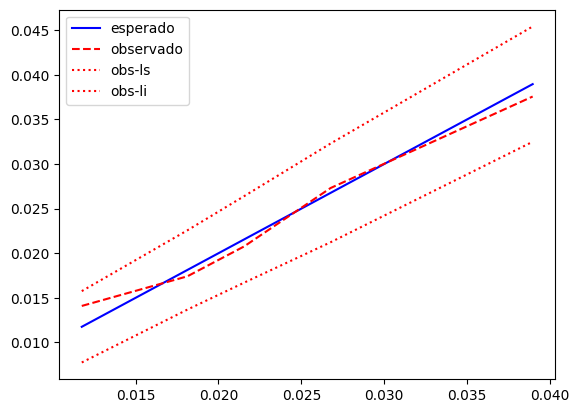

In [296]:
perfil_var(df2, 'score', ncat=5)

### Tabela de ganhos

In [297]:
df3 = df2.sort_values(by='score', ascending=False).reset_index().copy()
df3['tx_mau_acum'] = df3.mau.cumsum()/df3.shape[0]

df3['pct_mau_acum'] = df3.mau.cumsum()/df3.mau.sum()
# Redução dos maus
df3['red_mau_acum'] = 1-df3.pct_mau_acum

df3['pct_aprovacao'] = np.array(range(df3.shape[0]))/df3.shape[0]
df3.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,...,possui_fone,possui_email,qt_pessoas_residencia,mau,bom,score,tx_mau_acum,pct_mau_acum,red_mau_acum,pct_aprovacao
0,11099,F,N,N,0,Working,Academic/Higher,Widow,House / apartment,42.898630,...,1,1,1.0,0,1,0.096105,0.00000,0.000000,1.000000,0.00000
1,11680,F,N,N,0,Working,lower/Secondary,Widow,With parents,28.054795,...,1,0,1.0,0,1,0.081947,0.00000,0.000000,1.000000,0.00006
2,11681,F,N,N,0,Working,lower/Secondary,Widow,With parents,28.054795,...,1,0,1.0,0,1,0.081947,0.00000,0.000000,1.000000,0.00012
3,14030,F,N,N,0,Working,lower/Secondary,Widow,House / apartment,43.528767,...,1,0,1.0,1,0,0.076838,0.00006,0.002564,0.997436,0.00018
4,16626,F,N,N,0,Working,lower/Secondary,Widow,House / apartment,43.528767,...,1,0,1.0,1,0,0.076838,0.00012,0.005128,0.994872,0.00024


In [298]:
fig = px.line(df3, x="pct_aprovacao", y="tx_mau_acum", title='Taxa de maus por %aprovação')
fig.show()

In [299]:
fig = px.line(df3, x="pct_aprovacao", y="red_mau_acum", title='Redução na inadimplência por %aprovação')
fig.show()

In [300]:
df2['idade_cat'] = pd.qcut(df2['idade'], 5, duplicates='drop')

tmp = df2.sort_values(by=['idade_cat','score'], ascending=True).copy()
tmp['freq']=1

tmp['freq_ac'] = tmp.groupby(['idade_cat'])['freq'].transform(lambda x: x.cumsum())
tmp['maus_ac'] = tmp.groupby(['idade_cat'])['mau'].transform(lambda x: x.cumsum())
tmp['freq_fx_idade'] = tmp.groupby(['idade_cat'])['freq'].transform(lambda x: x.sum())

tmp['pct_aprovados'] = tmp.freq_ac/tmp['freq_fx_idade']
tmp['tx_maus_pto_corte'] = tmp['maus_ac']/tmp['freq_ac']


In [301]:
fig = px.line(tmp, x="score", y="pct_aprovados", color='idade_cat', title='Taxa de maus por %aprovação')
fig.show()

## 6. Implementação
Dependendo do tamanho da empresa, tipicamente esta etapa é especificada a uma área especialista. Para empresas mais enxutas, a mesma equipe (ou o mesmo profissional) fica encarregado desta etapa. Há diversas formas diferentes de se implementar um modelo de scorecard, mas em todas elas devem ser executados as seguintes atividades:

- Homologação: Consiste em verificar da forma mais exaustiva possível que foi implementada a equação/modelo desejado, e sem erros. Tipicamente é preparada uma massa de testes, e executada pelo programa de implementação, antes de colocá-lo em produção efetivamente.
- Desenvolvimento da estratégia: O modelo será utilizado para tomar decisões. Nas etapas anteriores, o que foi produzido é uma equação que avalia a probabilidade de um evento. Não há decisões efetivas de negócio aqui. A estratégia consiste nas decisões a serem direcionadas em detrimento desses escores.

## 7. Pós implementação

Após a implementação, há duas características a serem monitoradas:

- O desempenho da estratégia: consiste em monitorar o negócio, a inadimplência, a qualidade do crédito, se a estratégia especificada está sendo respeitada etc. Tudo isso em geral se deseja ver ao longo do tempo, com análises e filtragens específicas, por produto, regional etc.
- O desempenho do modelo: Todo produto tem um ciclo de vida, o mesmo se espera de um modelo como o de crediscoring. Os diferentes níveis de risco estão de fato resultando em níveis diferentes de inadimplência? As variáveis continuam com o mesmo poder de discriminação? Os patamares gerais de inadimplência permanecem? Todas essas são características que podem vir diferente da expectativa quando o modelo entra no ar pela primeira vez, e podem se alterar no tempo. Dependendo deste monitoramento podem se disparar diversas ações de ajustes no modelo.